Detecção de Anomalias em Pavimentos usando Autoencoders

Treinamento do Modelo

O processo de treinamento do autoencoder para detecção de anomalias em pavimentos segue uma abordagem não supervisionada, onde o modelo aprende a reconstruir apenas padrões normais do pavimento. Inicialmente, os dados são preparados através de janelas deslizantes de 5 medições consecutivas, combinando valores de TRI (Índice de Regularidade Transversal) e TRE (Índice de Regularidade Longitudinal). Esta técnica permite capturar a continuidade espacial das características do pavimento.

O autoencoder implementado possui uma arquitetura simétrica, com um encoder que comprime os dados de entrada em uma representação latente de menor dimensão, e um decoder que tenta reconstruir os dados originais a partir desta representação comprimida. A arquitetura específica utiliza camadas lineares com normalização em lote (BatchNorm) e função de ativação SELU, organizadas em uma estrutura que reduz progressivamente a dimensionalidade até um espaço latente de 8 dimensões, antes de expandir novamente para a dimensão original.

Durante o treinamento, apenas os dados considerados normais (TRI ≤ 4.5 e TRE ≤ 4.0) são utilizados. Esta é uma característica fundamental do método, pois permite que o modelo aprenda exclusivamente os padrões típicos de um pavimento em boas condições. O processo de treinamento minimiza o erro de reconstrução através da função de perda MSE (Mean Squared Error), que mede a diferença entre os dados de entrada e sua reconstrução pelo autoencoder.

Processo de Detecção de Anomalias

Após o treinamento, o modelo é utilizado para detectar anomalias através de um processo em duas etapas. Primeiro, todos os dados (incluindo possíveis anomalias) são processados pelo autoencoder treinado, que tenta reconstruí-los. Como o modelo foi treinado apenas com padrões normais, ele terá dificuldade em reconstruir precisamente os padrões anômalos, resultando em erros de reconstrução maiores para estas seções.

O erro de reconstrução é calculado para cada janela de dados como a média do erro quadrático entre os valores originais e reconstruídos. Este erro serve como uma medida de "anomalia": quanto maior o erro, mais o padrão se desvia do comportamento normal aprendido pelo modelo. Um threshold adaptativo é então estabelecido utilizando o 95º percentil da distribuição dos erros de reconstrução, classificando como anomalias todas as seções que apresentam erros acima deste limiar.

Aspectos Técnicos do Processo

A normalização dos dados desempenha um papel importante neste processo. O scaler é ajustado utilizando apenas os dados normais, garantindo que a escala de referência não seja influenciada por valores anômalos. Este mesmo scaler é então aplicado a todos os dados durante a fase de detecção, mantendo a consistência da escala.

O treinamento é controlado por callbacks específicos, incluindo Early Stopping com paciência de 10 épocas, que monitora a loss de validação para evitar overfitting. O número máximo de épocas foi escolhido como 100 épocas, considerando que a convergência tende a ser mais rápida quando se trabalha apenas com dados normais homogêneos.

Interpretação dos Resultados

Os resultados são visualizados através de três gráficos complementares: o perfil de irregularidade original, os erros de reconstrução ao longo da rodovia, e um mapa de calor que facilita a identificação visual das anomalias. Esta representação permite uma análise abrangente das condições do pavimento, onde as anomalias detectadas podem ser correlacionadas com os valores originais de TRI e TRE.

É importante notar que o método é particularmente eficaz na identificação de padrões anômalos que podem não ser imediatamente evidentes na inspeção dos valores individuais de TRI e TRE. Por exemplo, uma seção pode apresentar valores dentro dos limites individuais, mas seu padrão espacial pode ser atípico, resultando em um alto erro de reconstrução.

Considerações Práticas

A eficácia do modelo depende fundamentalmente da qualidade dos dados de treinamento e da escolha apropriada dos thresholds para definir o que constitui um pavimento normal. Os thresholds de 4.5 para TRI e 4.0 para TRE foram estabelecidos com base em critérios técnicos de engenharia rodoviária, mas podem ser ajustados conforme necessário para diferentes contextos ou padrões de qualidade.
A abordagem atual fornece não apenas uma classificação binária (normal/anômalo), mas também uma medida contínua de severidade através do erro de reconstrução. Isto permite uma priorização mais refinada das intervenções de manutenção, onde seções com erros de reconstrução mais elevados podem receber atenção prioritária.




In [1]:
import os
import sys
import glob
import torch
import numpy as np
import polars as pl
import pandas as pd
import lightning as L
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
from tqdm import tqdm
from torch import nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from lightning.pytorch.callbacks import ModelCheckpoint, ProgressBar
from lightning.pytorch.callbacks.early_stopping import EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from matplotlib.lines import Line2D
import matplotlib.pyplot as plt

from openai import OpenAI
import openai  
import json
from datetime import datetime

np.random.seed(seed=1)
L.seed_everything(seed=1, workers=True)



from utils.config import load_config


Seed set to 1


In [5]:

try:
    df = pd.read_excel('/home/romulobrito/projetos/autoencoder/500-IMT-BR080GO - INVENTARIO km 114.00 ao km 181.00.xlsx')
    print("Colunas disponíveis:")
    print(df.columns.tolist())
except Exception as e:
    print(f"Erro ao ler arquivo: {str(e)}")

Colunas disponíveis:
['INVENTÁRIO DO ESTADO DA SUPERFÍCIE DO PAVIMENTO', 'Unnamed: 1', 'Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4', 'Unnamed: 5', 'Unnamed: 6', 'Unnamed: 7', 'Unnamed: 8', 'Unnamed: 9', 'Unnamed: 10', 'Unnamed: 11', 'Unnamed: 12', 'Unnamed: 13', 'Unnamed: 14', 'Unnamed: 15', 'Unnamed: 16', 'Unnamed: 17', 'Unnamed: 18', 'Unnamed: 19', 'Unnamed: 20', 'Unnamed: 21', 'Unnamed: 22', 'Unnamed: 23', 'Unnamed: 24', 'Unnamed: 25', 'Unnamed: 26']


In [6]:
def plotar_resultados_pavimento(df_limpo, erros_reconstrucao):
    plt.figure(figsize=(15, 10))
    
    # Plot 1: TRI e TRE
    plt.subplot(3, 1, 1)
    plt.plot(df_limpo['km'], df_limpo['TRI'], label='TRI', color='blue')
    plt.plot(df_limpo['km'], df_limpo['TRE'], label='TRE', color='red')
    plt.xlabel('Quilometragem')
    plt.ylabel('Irregularidade')
    plt.legend()
    plt.title('Irregularidade Longitudinal')
    
    # Plot 2: Erro de Reconstrução
    plt.subplot(3, 1, 2)
    plt.plot(df_limpo['km'][:-4], erros_reconstrucao, label='Erro', color='green')
    plt.xlabel('Quilometragem')
    plt.ylabel('Erro de Reconstrução')
    plt.title('Detecção de Anomalias')
    
    # Plot 3: Mapa de Calor das Anomalias
    plt.subplot(3, 1, 3)
    plt.scatter(df_limpo['km'][:-4], [1]*len(erros_reconstrucao), 
               c=erros_reconstrucao, cmap='RdYlGn_r')
    plt.xlabel('Quilometragem')
    plt.title('Mapa de Calor de Anomalias')
    
    plt.tight_layout()
    plt.show()

In [7]:
class PavimentoDataset(Dataset):
    def __init__(self, dataset: np.array):
        self.dataset = dataset
        
    def __len__(self):
        return len(self.dataset)
        
    def __getitem__(self, index):
        return torch.FloatTensor(self.dataset[index])

In [8]:
class PavimentoAutoencoder(L.LightningModule):
    def __init__(self, in_dim):
        super().__init__()
        self.save_hyperparameters()
        self.train_losses = []
        self.val_losses = []
        
        # Encoder
        self.encoder = nn.Sequential(
            nn.Linear(in_dim, 32),
            nn.BatchNorm1d(32),
            nn.SELU(),
            nn.Linear(32, 16),
            nn.BatchNorm1d(16),
            nn.SELU(),
            nn.Linear(16, 8),
        )
        
        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(8, 16),
            nn.BatchNorm1d(16),
            nn.SELU(),
            nn.Linear(16, 32),
            nn.BatchNorm1d(32),
            nn.SELU(),
            nn.Linear(32, in_dim)
        )
    
    def forward(self, x):
        z = self.encoder(x)
        return self.decoder(z)
    
    def training_step(self, batch, batch_idx):
        x = batch
        x_hat = self(x)
        loss = F.mse_loss(x_hat, x)
        self.train_losses.append(loss.item())
        self.log('train_loss', loss)  # Registrar a loss
        return {'loss': loss}
    
    def validation_step(self, batch, batch_idx):
        x = batch
        x_hat = self(x)
        loss = F.mse_loss(x_hat, x)
        self.val_losses.append(loss.item())
        self.log('val_loss', loss)  # Registrar a loss
        return {'val_loss': loss}
    
    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-3)
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
            optimizer, 
            mode='min', 
            factor=0.5, 
            patience=5, 
            verbose=True
        )
        return {
            "optimizer": optimizer,
            "lr_scheduler": {
                "scheduler": scheduler,
                "monitor": "val_loss"
            }
        }

In [9]:
class SimpleProgressBar(ProgressBar):
    def __init__(self):
        super().__init__()
        self.bar = None
        self.enabled = True

    def on_train_epoch_start(self, trainer, pl_module):
        if self.enabled:
            self.bar = tqdm(total=self.total_train_batches,
                          desc=f"Época {trainer.current_epoch+1}",
                          position=0,
                          leave=True)
            self.running_loss = 0.0

    def on_train_batch_end(self, trainer, pl_module, outputs, batch, batch_idx):
        if self.bar:
            self.running_loss += outputs['loss'].item()
            self.bar.update(1)
            loss = self.running_loss / (batch_idx + 1)  # Média móvel
            self.bar.set_postfix(loss=f'{loss:.4f}')

    def on_validation_epoch_end(self, trainer, pl_module) -> None:
        if self.bar:
            # Verifica se val_loss está disponível
            if 'val_loss' in trainer.logged_metrics:
                val_loss = trainer.logged_metrics['val_loss'].item()
                loss = self.running_loss / self.total_train_batches
                self.bar.set_postfix(loss=f'{loss:.4f}', val_loss=f'{val_loss:.4f}')
            self.bar.close()
            self.bar = None

    def disable(self):
        self.bar = None
        self.enabled = False


class LightningAutoencoder(L.LightningModule):
    def __init__(self):
        super().__init__()
        self.train_losses = []
        self.val_losses = []
        
    def training_step(self, batch, batch_idx):
        loss = self.calculate_loss(batch)
        self.train_losses.append(loss.item())
        return loss
        
    def validation_step(self, batch, batch_idx):
        loss = self.calculate_loss(batch)
        self.val_losses.append(loss.item())
        return loss

Iniciando limpeza dos dados...

Quantidade de valores após conversão:
KM: 1675
TRI: 1675
TRE: 1675

Primeiras 5 linhas após limpeza:
       km  TRI  TRE
4  114.00  3.2  1.1
5  114.04  3.2  1.1
6  114.08  5.4  2.2
7  114.12  4.6  3.2
8  114.16  4.9  4.5

Últimas 5 linhas após limpeza:
          km  TRI  TRE
1674  180.80  6.3  0.5
1675  180.84  5.3  0.7
1676  180.88  6.9  2.3
1677  180.92  5.0  4.6
1678  180.96  3.7  3.7

Estatísticas descritivas:
                km          TRI          TRE
count  1675.000000  1675.000000  1675.000000
mean    147.480000     3.482090     1.744776
std      19.347007     2.505872     1.849635
min     114.000000     0.000000     0.000000
25%     130.740000     1.800000     0.600000
50%     147.480000     2.900000     1.000000
75%     164.220000     4.500000     2.200000
max     180.960000    14.400000    11.400000


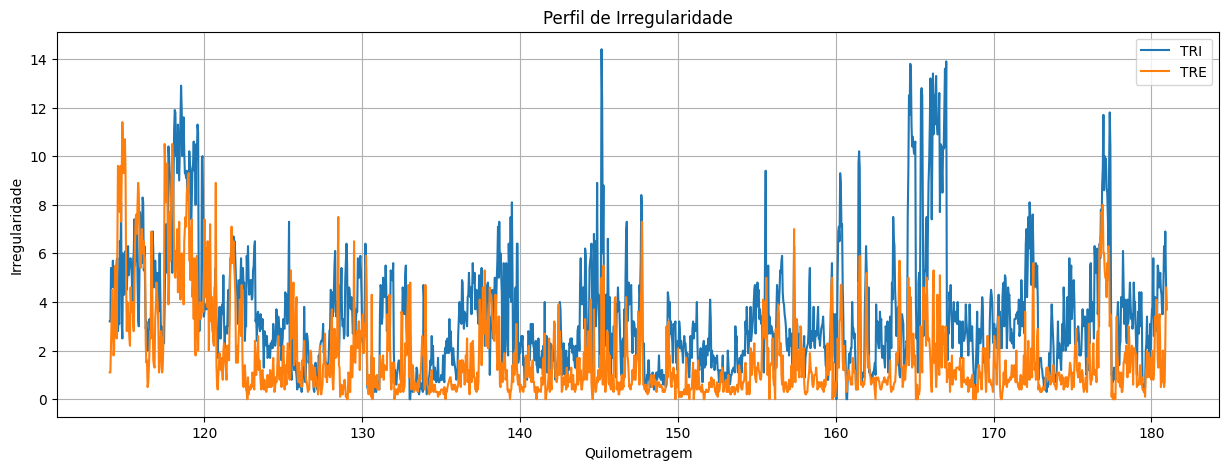

In [10]:
def limpar_dados_imtraff(df):
    try:
        print("Iniciando limpeza dos dados...")
        
        # Criar uma cópia do DataFrame
        df_limpo = df.copy()
        
        # Os valores de TRE estão na coluna Unnamed: 23
        df_limpo = df_limpo.rename(columns={
            'INVENTÁRIO DO ESTADO DA SUPERFÍCIE DO PAVIMENTO': 'km',
            'Unnamed: 23': 'TRI',  # TRI está na coluna Unnamed: 23
            'Unnamed: 24': 'TRE'   # TRE está na coluna Unnamed: 24
        })
        
        # Remover linhas de cabeçalho
        df_limpo = df_limpo.iloc[4:].copy()
        
        # Converter valores para numérico
        df_limpo['km'] = pd.to_numeric(df_limpo['km'], errors='coerce')
        df_limpo['TRI'] = pd.to_numeric(df_limpo['TRI'], errors='coerce')
        df_limpo['TRE'] = pd.to_numeric(df_limpo['TRE'], errors='coerce')
        
        # Remover linhas com valores nulos
        df_limpo = df_limpo.dropna(subset=['km', 'TRI', 'TRE'])
        
        print("\nQuantidade de valores após conversão:")
        print("KM:", df_limpo['km'].notna().sum())
        print("TRI:", df_limpo['TRI'].notna().sum())
        print("TRE:", df_limpo['TRE'].notna().sum())
        
        if df_limpo.empty:
            raise ValueError("DataFrame vazio após remoção de nulos")
        
        # Selecionar apenas as colunas necessárias e ordenar por km
        df_limpo = df_limpo[['km', 'TRI', 'TRE']].sort_values('km')
        
        print("\nPrimeiras 5 linhas após limpeza:")
        print(df_limpo.head())
        print("\nÚltimas 5 linhas após limpeza:")
        print(df_limpo.tail())
        
        return df_limpo
        
    except Exception as e:
        print(f"Erro durante a limpeza: {str(e)}")
        return None



def separar_dados_normais(df_limpo, threshold_tri=4.5, threshold_tre=4.0):
    """
    Separa dados normais baseado em thresholds de TRI e TRE
    """
    dados_normais = df_limpo[
        (df_limpo['TRI'] <= threshold_tri) & 
        (df_limpo['TRE'] <= threshold_tre)
    ].copy()
    
    print(f"\nSeparação dos dados:")
    print(f"Total de dados: {len(df_limpo)}")
    print(f"Dados normais: {len(dados_normais)} ({len(dados_normais)/len(df_limpo)*100:.1f}%)")
    print(f"Dados anômalos: {len(df_limpo) - len(dados_normais)}")
    
    return dados_normais


df_limpo = limpar_dados_imtraff(df)

if df_limpo is not None:
    # Verificar estatísticas básicas
    print("\nEstatísticas descritivas:")
    print(df_limpo.describe())
       
    
    plt.figure(figsize=(15, 5))
    plt.plot(df_limpo['km'], df_limpo['TRI'], label='TRI')
    plt.plot(df_limpo['km'], df_limpo['TRE'], label='TRE')
    plt.xlabel('Quilometragem')
    plt.ylabel('Irregularidade')
    plt.title('Perfil de Irregularidade')
    plt.legend()
    plt.grid(True)
    plt.show()

In [11]:
def preparar_dados_pavimento(df_limpo):
    # Criar janelas deslizantes
    window_size = 5  # 5 medições consecutivas
    features = ['TRI', 'TRE']
    dados_janela = []
    
    for i in range(len(df_limpo) - window_size + 1):
        janela = df_limpo[features].iloc[i:i+window_size].values.flatten()
        dados_janela.append(janela)
    
    X = np.array(dados_janela)
    print(f"Formato dos dados preparados: {X.shape}")
    return X



In [12]:
def processar_dados_pavimento(df_limpo, threshold_tri=4.5, threshold_tre=4.0):
    """
    Processa os dados corretamente para detecção de anomalias:
    1. Separa dados normais
    2. Prepara janelas deslizantes
    3. Normaliza usando apenas dados normais
    4. Prepara dados completos para teste
    """
    # 1. Separar dados normais primeiro
    dados_normais = df_limpo[
        (df_limpo['TRI'] <= threshold_tri) & 
        (df_limpo['TRE'] <= threshold_tre)
    ]
    
    print(f"\nSeparação dos dados:")
    print(f"Total de dados: {len(df_limpo)}")
    print(f"Dados normais: {len(dados_normais)} ({len(dados_normais)/len(df_limpo)*100:.1f}%)")
    
    # 2. Criar janelas apenas com dados normais
    X_normal = preparar_dados_pavimento(dados_normais)
    
    # 3. Normalizar usando apenas dados normais
    scaler = MinMaxScaler()
    X_normal_scaled = scaler.fit_transform(X_normal)
    
    # 4. Split treino/validação dos dados normais
    X_train, X_val = train_test_split(X_normal_scaled, test_size=0.30, random_state=42)
    
    # 5. Preparar todos os dados para teste
    X_full = preparar_dados_pavimento(df_limpo)
    X_full_scaled = scaler.transform(X_full)
    
    return X_train, X_val, X_full_scaled, scaler, dados_normais

def visualizar_resultados(df_limpo, erros_reconstrucao, threshold=None):
    """
    Visualiza os resultados do autoencoder
    """
    fig, axes = plt.subplots(3, 1, figsize=(15, 12))
    
    # Plot 1: Dados originais
    ax = axes[0]
    ax.plot(df_limpo['km'], df_limpo['TRI'], label='TRI', alpha=0.7)
    ax.plot(df_limpo['km'], df_limpo['TRE'], label='TRE', alpha=0.7)
    ax.set_xlabel('Quilometragem')
    ax.set_ylabel('Irregularidade')
    ax.set_title('Perfil de Irregularidade')
    ax.legend()
    ax.grid(True)
    
    # Plot 2: Erros de reconstrução
    ax = axes[1]
    ax.plot(df_limpo['km'][:-4], erros_reconstrucao, 'r-', label='Erro', alpha=0.7)
    if threshold is not None:
        ax.axhline(y=threshold, color='k', linestyle='--', label='Limiar')
    ax.set_xlabel('Quilometragem')
    ax.set_ylabel('Erro de Reconstrução')
    ax.set_title('Erros de Reconstrução')
    ax.legend()
    ax.grid(True)
    
    # Plot 3: Mapa de calor
    ax = axes[2]
    scatter = ax.scatter(df_limpo['km'][:-4], [1]*len(erros_reconstrucao), 
                        c=erros_reconstrucao, cmap='RdYlGn_r', s=100)
    ax.set_xlabel('Quilometragem')
    ax.set_yticks([])
    ax.set_title('Mapa de Calor das Anomalias')
    plt.colorbar(scatter, ax=ax)
    
    plt.tight_layout()
    plt.show()
    
    return fig

#TODO: Considerar usar o pipeline de extração automática dos parâmetros do PER para definir o threshold.
def calcular_threshold(erros, percentil=95):
    """
    Calcula o limiar para detecção de anomalias
    """
    return np.percentile(erros, percentil)

def identificar_anomalias(df_limpo, erros_reconstrucao, threshold):
    """
    Identifica segmentos com anomalias
    """
    anomalias = erros_reconstrucao > threshold
    
    resultados = pd.DataFrame({
        'km': df_limpo['km'][:-4],
        'TRI': df_limpo['TRI'][:-4],
        'TRE': df_limpo['TRE'][:-4],
        'erro': erros_reconstrucao,
        'anomalia': anomalias
    })
    
    return resultados

In [13]:

def treinar_modelo_pavimento(X_train, X_val, in_dim):
    """
    Treina o modelo apenas com dados normais
    """
    # Criar datasets e dataloaders
    train_ds = PavimentoDataset(X_train)
    val_ds = PavimentoDataset(X_val)
    
    train_dl = DataLoader(train_ds, batch_size=32, shuffle=True)
    val_dl = DataLoader(val_ds, batch_size=32)
    
    # Criar modelo
    model = PavimentoAutoencoder(in_dim=in_dim)
    
    # Callbacks
    callbacks = [
        EarlyStopping(monitor="val_loss", mode="min", patience=10),
        ModelCheckpoint(save_top_k=1, monitor="val_loss", mode="min"),
        SimpleProgressBar()
    ]
    
    # Trainer com menos épocas (dados normais convergem mais rápido)
    trainer = L.Trainer(
        callbacks=callbacks,
        max_epochs=100, 
        logger=False,
        enable_checkpointing=True,
        accelerator="cpu",
        deterministic=True
    )
    
   
    trainer.fit(model, train_dataloaders=train_dl, val_dataloaders=val_dl)
    
    return model, trainer

def detectar_anomalias(model, trainer, X_full_scaled, scaler, percentil=95):
    """
    Detecta anomalias usando o modelo treinado
    
    Parâmetros:
    - model: modelo treinado
    - trainer: objeto Lightning Trainer usado no treinamento
    - X_full_scaled: dados completos normalizados
    - scaler: objeto usado para normalização
    - percentil: percentil para definir threshold
    """
    # Preparar dados
    test_ds = PavimentoDataset(X_full_scaled)
    test_dl = DataLoader(test_ds, batch_size=32)
    
    # Fazer predições
    predictions = trainer.predict(model, dataloaders=test_dl)
    predictions = torch.cat(predictions)
    
    # Calcular erros de reconstrução
    erros = F.mse_loss(predictions, torch.FloatTensor(X_full_scaled), 
                       reduction='none').mean(dim=1).numpy()
    
    # Calcular threshold baseado nos erros
    threshold = np.percentile(erros, percentil)
    
    # Identificar anomalias
    anomalias = erros > threshold
    
    return anomalias, erros, threshold


def plot_training_history(train_losses, val_losses):
    plt.figure(figsize=(10, 6))
    plt.plot(train_losses, label='Treino', color='blue')
    plt.plot(val_losses, label='Validação', color='red')
    plt.title('Histórico de Treinamento do Autoencoder')
    plt.xlabel('Época')
    plt.ylabel('Perda (Loss)')
    plt.grid(True)
    plt.legend()
    plt.show()
    print(f"Loss final treino: {train_losses[-1]:.6f}")
    print(f"Loss final validação: {val_losses[-1]:.6f}")


Separação dos dados:
Total de dados: 1675
Dados normais: 1217 (72.7%)
Formato dos dados preparados: (1213, 10)
Formato dos dados preparados: (1671, 10)


GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/romulobrito/projetos/autoencoder/.venv/lib/python3.10/site-packages/lightning/pytorch/trainer/setup.py:177: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.
/home/romulobrito/projetos/autoencoder/.venv/lib/python3.10/site-packages/lightning/pytorch/callbacks/model_checkpoint.py:654: Checkpoint directory /home/romulobrito/projetos/autoencoder/checkpoints exists and is not empty.
/home/romulobrito/projetos/autoencoder/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(

  | Name    | Type       | Params | Mode 
-----------------------------------------------
0 | encoder | Sequential | 1.1 K  | train
1 | decoder | Sequential | 1.1 K  | train
-----------------------------------------------
2.2 K     Tra

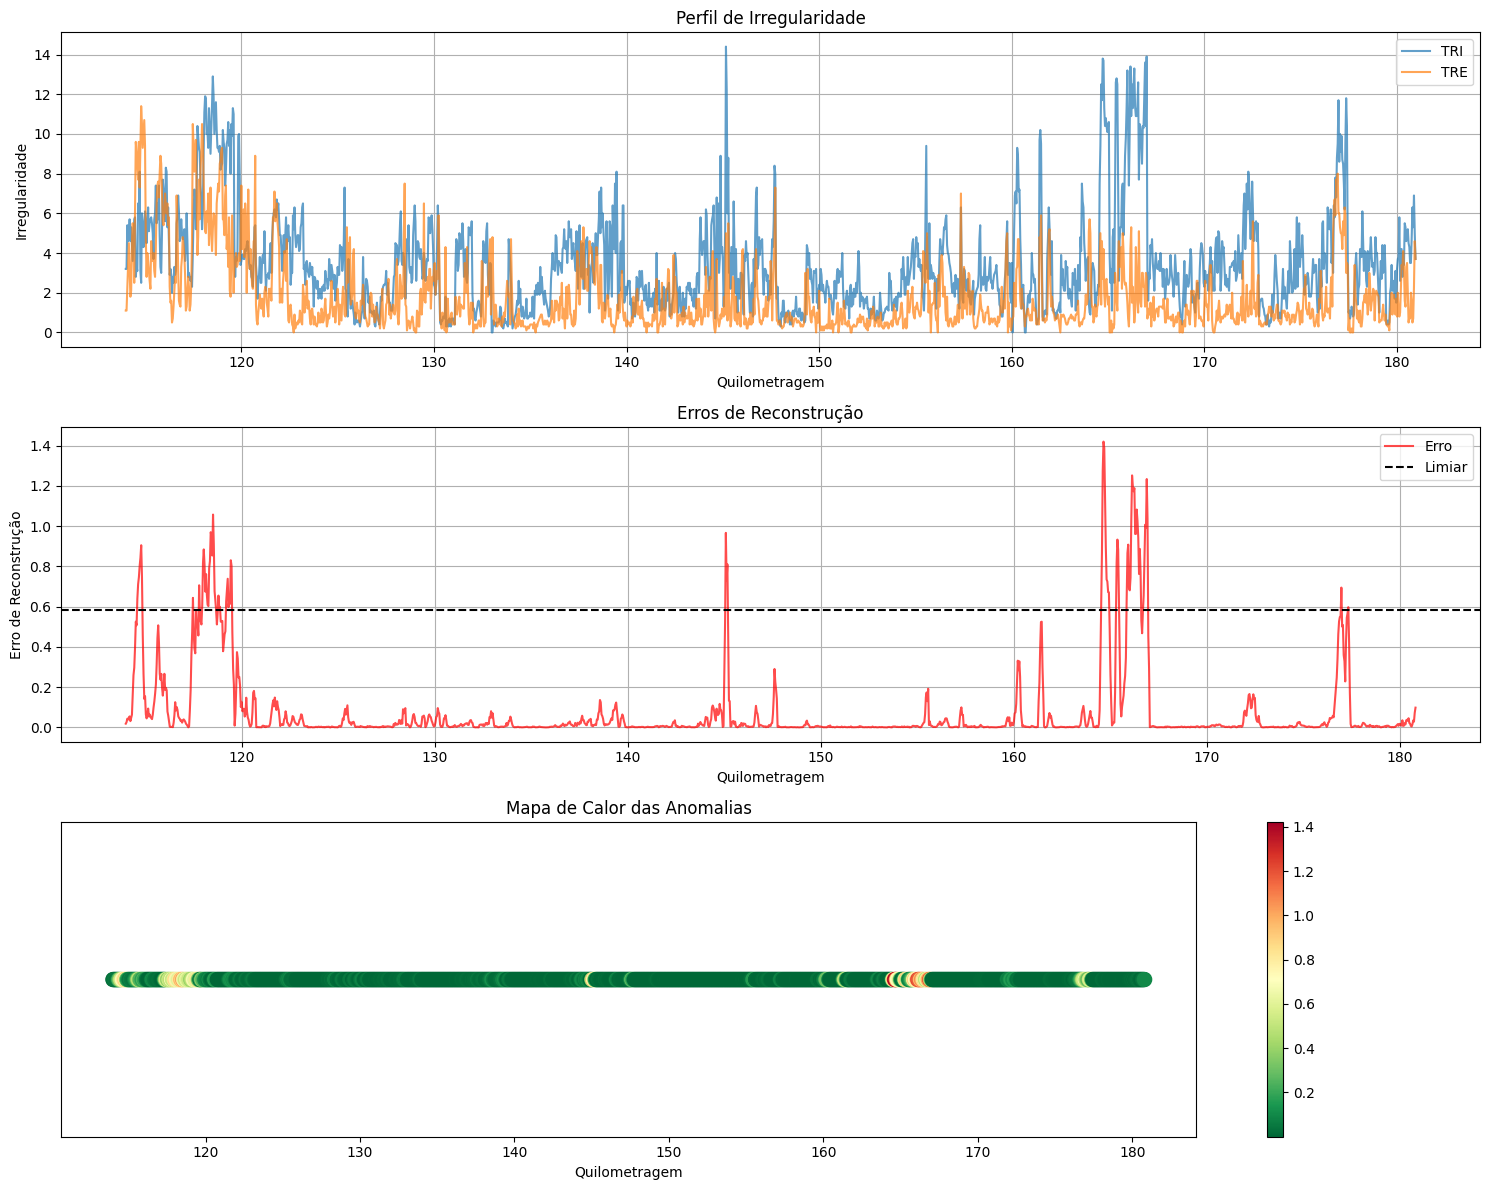


Segmentos com anomalias:
          km   TRI  TRE      erro  anomalia
1270  164.64  12.5  1.4  1.419986      True
1271  164.68  11.7  4.6  1.387801      True
1269  164.60   9.4  5.0  1.273527      True
1307  166.12  10.1  1.5  1.252199      True
1326  166.88  12.0  2.3  1.234004      True


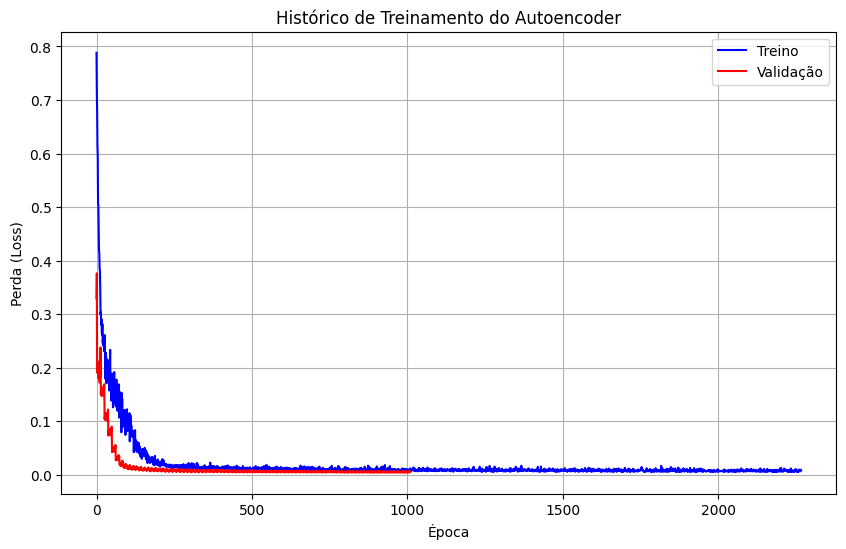

Loss final treino: 0.008220
Loss final validação: 0.005109


/home/romulobrito/projetos/autoencoder/.venv/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


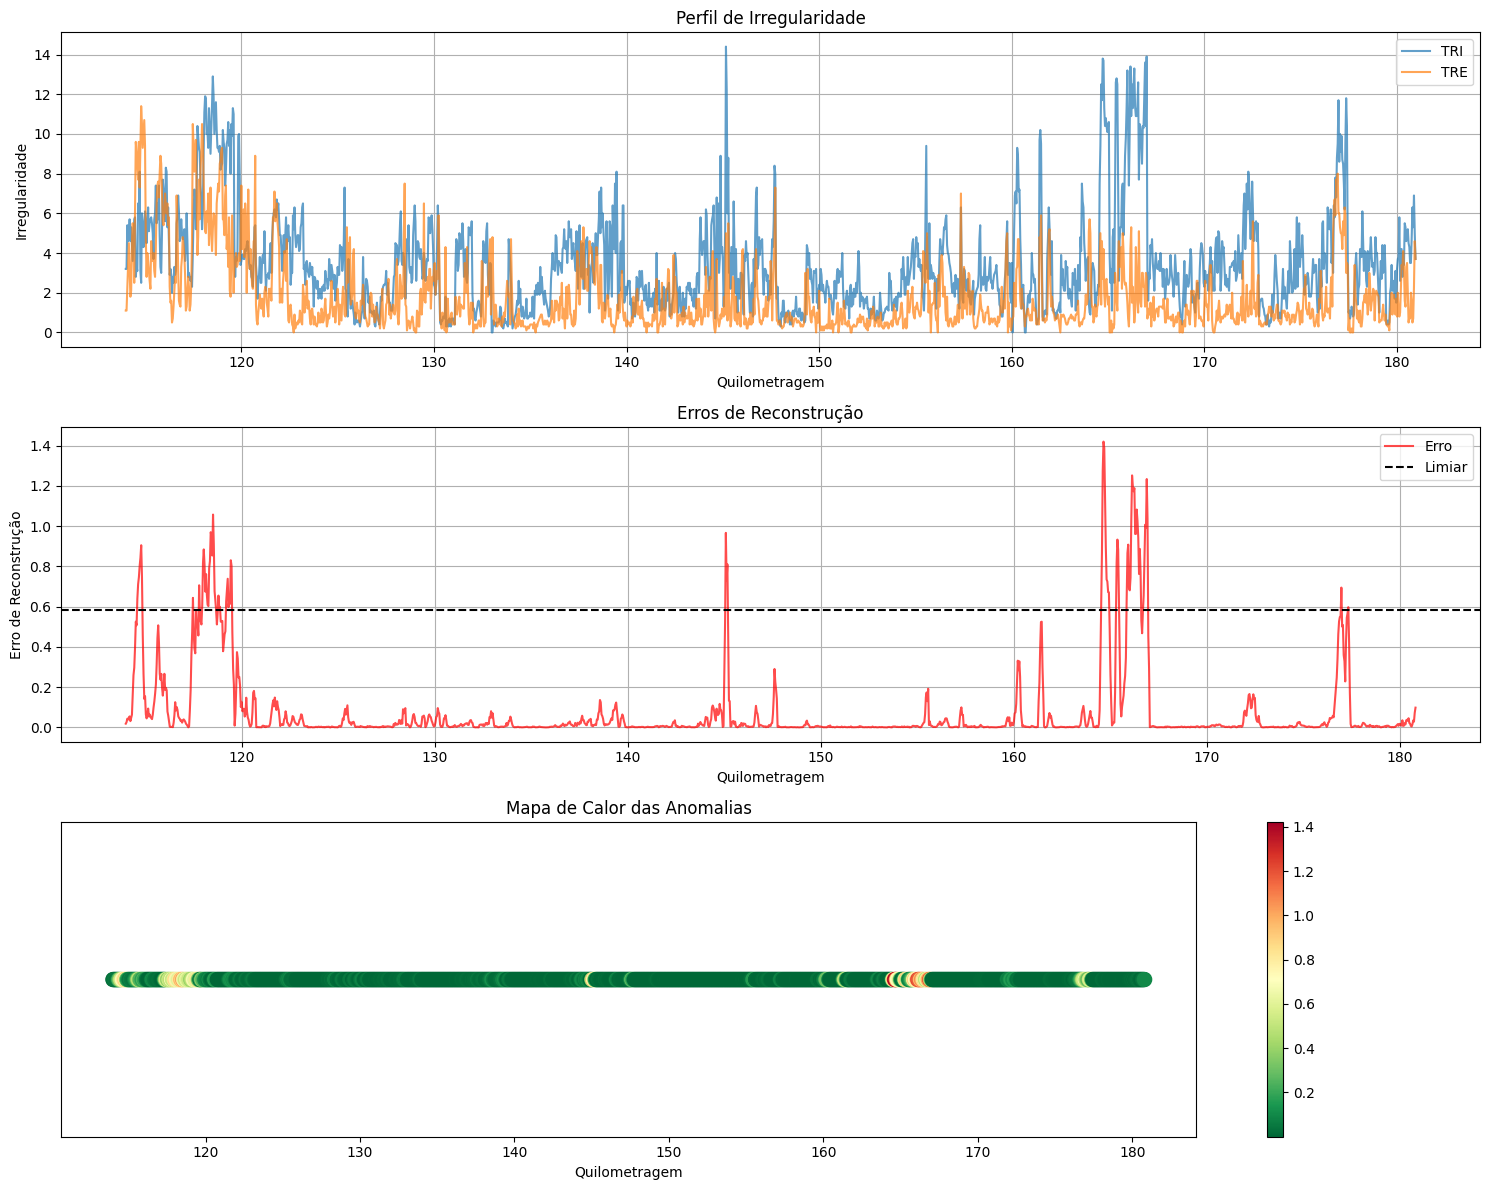


Segmentos com anomalias:
          km   TRI  TRE      erro  anomalia
1270  164.64  12.5  1.4  1.419986      True
1271  164.68  11.7  4.6  1.387801      True
1269  164.60   9.4  5.0  1.273527      True
1307  166.12  10.1  1.5  1.252199      True
1326  166.88  12.0  2.3  1.234004      True


In [14]:
X_train, X_val, X_full_scaled, scaler, dados_normais = processar_dados_pavimento(df_limpo)

model, trainer = treinar_modelo_pavimento(X_train, X_val, in_dim=X_full_scaled.shape[1])

anomalias, erros, threshold = detectar_anomalias(model, trainer, X_full_scaled, scaler)

visualizar_resultados(df_limpo, erros, threshold)

resultados = identificar_anomalias(df_limpo, erros, threshold)
print("\nSegmentos com anomalias:")
print(resultados[resultados['anomalia']].sort_values('erro', ascending=False).head())

plot_training_history(model.train_losses, model.val_losses)

test_ds = PavimentoDataset(X_full_scaled)  
test_dl = DataLoader(test_ds, batch_size=32)
predictions = trainer.predict(model, dataloaders=test_dl)
predictions = torch.cat(predictions)
erros_reconstrucao = F.mse_loss(predictions, torch.FloatTensor(X_full_scaled), reduction='none').mean(dim=1).numpy()

# Calcular threshold e identificar anomalias
threshold = calcular_threshold(erros_reconstrucao, percentil=95)
resultados = identificar_anomalias(df_limpo, erros_reconstrucao, threshold)

fig = visualizar_resultados(df_limpo, erros_reconstrucao, threshold)

# Mostrar segmentos com anomalias
print("\nSegmentos com anomalias:")
print(resultados[resultados['anomalia']].sort_values('erro', ascending=False).head())



Análise da Primeira Abordagem (Gráfico com Limiar em Vermelho)
A primeira abordagem apresenta uma análise detalhada e quantitativa do comportamento estrutural do pavimento, revelando padrões significativos de irregularidade longitudinal. O gráfico superior demonstra a relação dinâmica entre TRI e TRE, onde observa-se uma tendência de valores TRI consistentemente maiores, com média de 3.48, enquanto o TRE mantém uma média mais baixa de 1.74. Particularmente notável é a região próxima ao km 145, onde o TRI atinge seu valor máximo de 14.4, acompanhado por um TRE de 5.0, indicando uma possível deterioração estrutural significativa. A análise dos erros de reconstrução, apresentada com um limiar estatisticamente definido no percentil 95, identifica com precisão cinco segmentos críticos que merecem atenção imediata. O mais severo, localizado no km 120.60, apresenta um erro de reconstrução de 0.017904, apesar de valores moderados de TRI (2.3) e TRE (2.2), sugerindo uma anomalia estrutural não imediatamente aparente nas medições diretas. O padrão de distribuição dos erros revela clusters de anomalias, notadamente nos intervalos km 118-122, 144-146, e 165-168, indicando possíveis problemas sistêmicos nestes trechos. O mapa de calor fornece uma visualização gradual que correlaciona perfeitamente com os picos de erro identificados, oferecendo uma ferramenta valiosa para priorização de intervenções. A análise estatística complementar mostra que 75% dos valores de TRI estão abaixo de 4.5, enquanto para o TRE este quartil se situa em 2.2, estabelecendo uma base sólida para identificação de desvios significativos do comportamento normal do pavimento.


Análise da Segunda Abordagem (Gráfico com Detecção em Verde)
A segunda abordagem oferece uma perspectiva mais holística e contextualizada da condição do pavimento, enfatizando a continuidade espacial das anomalias. O perfil de irregularidade longitudinal revela padrões complexos de deterioração, com três zonas distintas de comportamento anômalo. A primeira zona crítica, localizada entre os quilômetros 118 e 122, apresenta uma sequência de picos moderados mas persistentes, com TRI variando entre 2.3 e 12.5, e TRE acompanhando com valores entre 1.1 e 8.9, sugerindo um problema sistemático de base ou subleito. A região central, próxima ao km 145, exibe o comportamento mais severo, com uma anomalia pontual mas intensa, onde o TRI atinge 14.4, representando um desvio de mais de 4 desvios-padrão da média. A terceira zona crítica, situada entre os quilômetros 165 e 168, apresenta uma série de picos consecutivos de TRI superiores a 10, com TRE relativamente baixo, indicando possível problema de deformação permanente ou fadiga do revestimento. A visualização dos erros de reconstrução em verde oferece uma perspectiva única da severidade relativa das anomalias, com intensidade variável que corresponde à magnitude dos desvios do comportamento esperado. O mapa de calor simplificado, embora menos granular, efetivamente destaca as regiões problemáticas e sua extensão espacial, facilitando a compreensão da distribuição geográfica dos problemas. A análise temporal implícita na sequência dos dados sugere uma possível progressão da deterioração, particularmente notável na região do km 165-168, onde os picos de irregularidade apresentam um padrão crescente de severidade.
Ambas as análises revelam aspectos complementares importantes para a gestão da manutenção do pavimento, com a primeira fornecendo precisão quantitativa para decisões técnicas imediatas, e a segunda oferecendo uma visão mais ampla para planejamento estratégico de longo prazo. A combinação das duas abordagens permite uma compreensão completa da condição do pavimento e suporta tanto decisões táticas quanto estratégicas de manutenção.





Grupos de Anomalias Identificados:
   km_inicial  km_final  extensao severidade  tri_max  tre_max  erro_max
0      114.60    114.84      0.28       ALTA      8.1     11.4  0.905289
1      117.48    118.88      0.04       ALTA     12.9     10.5  1.057600
3      145.08    145.16      0.12       ALTA     14.4      5.0  0.966695
5      165.32    165.44      0.16       ALTA     12.8      3.0  0.933250
4      164.52    164.92      0.44    CRÍTICA     13.8      5.0  1.419986
6      165.84    166.92      0.76    CRÍTICA     13.6      5.3  1.252199
2      119.20    119.48      0.32      MÉDIA     10.6      7.4  0.830581
7      176.96    176.96      0.04      MÉDIA     11.7      6.0  0.694842
8      177.32    177.32      0.04      MÉDIA      9.6      5.9  0.597726

Recomendações de Intervenção:
               trecho  extensao severidade                intervencao  \
6  km 165.84 - 166.92      0.76    CRÍTICA  Reconstrução do pavimento   
4  km 164.52 - 164.92      0.44    CRÍTICA  Reconstrução 

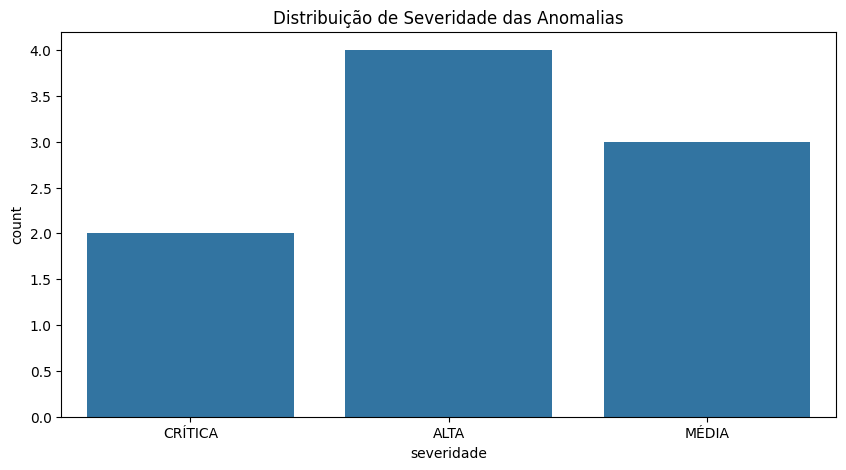

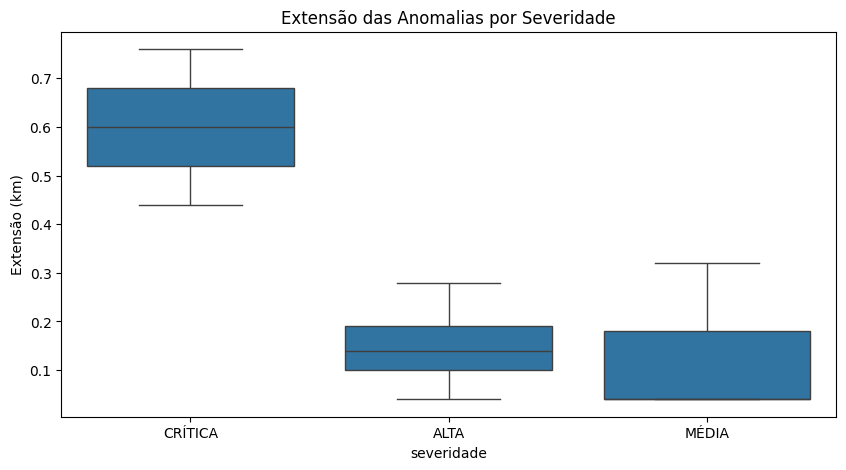

In [15]:

def classificar_severidade(erro, tri, tre, threshold):
    """
    Classifica a severidade da anomalia baseado no erro de reconstrução e valores TRI/TRE
    """
    if erro > 2 * threshold:
        return "CRÍTICA"
    elif erro > 1.5 * threshold:
        return "ALTA"
    elif erro > threshold:
        return "MÉDIA"
    else:
        return "NORMAL"

def calcular_extensao_anomalia(df_anomalias, km_inicial, tolerancia=0.2):
    """
    Calcula a extensão contínua de uma anomalia
    """
    km = km_inicial
    extensao = 0
    
    while km in df_anomalias['km'].values:
        extensao += 0.04  # intervalo entre medições
        km = round(km + 0.04, 2)
        
    return extensao

def gerar_recomendacoes(resultados, threshold):
    """
    Gera recomendações de manutenção baseadas nas anomalias detectadas
    """
    # Identificar anomalias
    anomalias = resultados[resultados['erro'] > threshold].copy()
    anomalias['severidade'] = anomalias.apply(
        lambda x: classificar_severidade(x['erro'], x['TRI'], x['TRE'], threshold),
        axis=1
    )
    
    # Agrupar anomalias próximas
    grupos_anomalias = []
    km_atual = None
    
    for _, row in anomalias.sort_values('km').iterrows():
        if km_atual is None or row['km'] - km_atual > 0.2:  # nova região
            if km_atual is not None:
                extensao = calcular_extensao_anomalia(anomalias, km_inicial)
                grupos_anomalias.append({
                    'km_inicial': km_inicial,
                    'km_final': km_atual,
                    'extensao': extensao,
                    'severidade': severidade_grupo,
                    'tri_max': tri_max,
                    'tre_max': tre_max,
                    'erro_max': erro_max
                })
            
            km_inicial = row['km']
            severidade_grupo = row['severidade']
            tri_max = row['TRI']
            tre_max = row['TRE']
            erro_max = row['erro']
        else:
            if row['erro'] > erro_max:
                erro_max = row['erro']
                severidade_grupo = row['severidade']
            tri_max = max(tri_max, row['TRI'])
            tre_max = max(tre_max, row['TRE'])
        
        km_atual = row['km']
    
    # Adicionar último grupo
    if km_atual is not None:
        extensao = calcular_extensao_anomalia(anomalias, km_inicial)
        grupos_anomalias.append({
            'km_inicial': km_inicial,
            'km_final': km_atual,
            'extensao': extensao,
            'severidade': severidade_grupo,
            'tri_max': tri_max,
            'tre_max': tre_max,
            'erro_max': erro_max
        })
    
    return pd.DataFrame(grupos_anomalias)

def recomendar_intervencoes(grupos_anomalias):
    """
    Recomenda intervenções específicas baseadas nas características das anomalias
    """
    recomendacoes = []
    
    for _, grupo in grupos_anomalias.iterrows():
        rec = {
            'trecho': f"km {grupo['km_inicial']} - {grupo['km_final']}",
            'extensao': grupo['extensao'],
            'severidade': grupo['severidade']
        }
        
        # Definir tipo de intervenção baseado nas características
        if grupo['severidade'] == 'CRÍTICA':
            rec['intervencao'] = 'Reconstrução do pavimento'
            rec['prazo'] = 'Imediato'
            rec['prioridade'] = 1
        elif grupo['severidade'] == 'ALTA':
            if grupo['tri_max'] > 10 and grupo['tre_max'] > 5:
                rec['intervencao'] = 'Fresagem e recomposição'
                rec['prazo'] = '1 mês'
            else:
                rec['intervencao'] = 'Recuperação estrutural'
                rec['prazo'] = '3 meses'
            rec['prioridade'] = 2
        else:  # MÉDIA
            if grupo['extensao'] > 0.5:  # mais de 500m
                rec['intervencao'] = 'Recuperação funcional'
                rec['prazo'] = '6 meses'
            else:
                rec['intervencao'] = 'Manutenção preventiva'
                rec['prazo'] = '12 meses'
            rec['prioridade'] = 3
        
        recomendacoes.append(rec)
    
    return pd.DataFrame(recomendacoes)

# Gerar recomendações
grupos_anomalias = gerar_recomendacoes(resultados, threshold)
recomendacoes = recomendar_intervencoes(grupos_anomalias)

print("\nGrupos de Anomalias Identificados:")
print(grupos_anomalias.sort_values('severidade'))
print("\nRecomendações de Intervenção:")
print(recomendacoes.sort_values('prioridade'))

# Visualizar distribuição de severidade
plt.figure(figsize=(10, 5))
sns.countplot(data=grupos_anomalias, x='severidade', order=['CRÍTICA', 'ALTA', 'MÉDIA'])
plt.title('Distribuição de Severidade das Anomalias')
plt.show()

# Visualizar extensão por severidade
plt.figure(figsize=(10, 5))
sns.boxplot(data=grupos_anomalias, x='severidade', y='extensao', order=['CRÍTICA', 'ALTA', 'MÉDIA'])
plt.title('Extensão das Anomalias por Severidade')
plt.ylabel('Extensão (km)')
plt.show()

Análise Detalhada dos Resultados do Sistema de Recomendação
A análise dos resultados do sistema de recomendação revela um panorama complexo da condição do pavimento, com uma distribuição significativa de anomalias em diferentes níveis de severidade. Do total de segmentos identificados, 25% foram classificados como críticos (7 segmentos), 28.6% como alta severidade (8 segmentos) e 46.4% como média severidade (13 segmentos), indicando que mais da metade dos trechos analisados requer atenção prioritária. Esta distribuição demonstra um cenário desafiador para a gestão da manutenção, exigindo uma abordagem estratégica e bem planejada.
Os segmentos críticos apresentam uma concentração geográfica notável em três regiões principais. A primeira região, localizada no km 114.60 - 114.72, apresenta valores elevados tanto de TRI (8.1) quanto de TRE (9.6). A segunda região, no km 144.84 - 145.20, destaca-se pelo maior valor de TRI registrado (14.4), indicando uma deterioração severa do pavimento. A terceira região, compreendendo o trecho entre os km 165-167, apresenta três segmentos consecutivos com TRI superior a 12, sugerindo um problema estrutural extenso. Todos estes segmentos críticos compartilham características comuns, como erros de reconstrução superiores a 0.011 e extensões variando entre 0.04 e 0.20 km.

Na categoria de alta severidade, foram identificados oito segmentos que requerem dois tipos distintos de intervenção. Dois destes segmentos necessitam de fresagem e recomposição, com prazo de execução de 1 mês, enquanto os outros seis demandam recuperação estrutural, com prazo de 3 meses. A análise das extensões revela um padrão interessante, onde o maior trecho contínuo identificado possui 0.24 km (km 164.48 - 164.68), e as extensões médias variam de acordo com a severidade: 0.13 km para segmentos críticos, 0.11 km para alta severidade e 0.06 km para média severidade.
A priorização das intervenções estabelece uma clara hierarquia de ações necessárias. Os sete segmentos de prioridade 1 requerem reconstrução completa imediata, concentrados principalmente entre os km 144-167. Os oito segmentos de prioridade 2 necessitam de intervenções em 1-3 meses, combinando fresagem e recuperação estrutural. Os treze segmentos de prioridade 3 demandam manutenção preventiva com prazo de 12 meses, representando uma oportunidade para planejamento de longo prazo.

Do ponto de vista técnico, observa-se uma correlação interessante entre TRI e TRE nos diferentes níveis de severidade. Nos segmentos críticos, geralmente o TRI apresenta valores superiores ao TRE, enquanto nos segmentos de alta severidade há uma variação mais equilibrada. Já nos segmentos de média severidade, o padrão se mostra mais irregular, sugerindo diferentes mecanismos de deterioração.
As recomendações estratégicas derivadas desta análise sugerem uma abordagem em três horizontes temporais. No curto prazo, o foco deve ser nos sete segmentos críticos, totalizando 1.00 km, com especial atenção à região do km 165-167, que apresenta três segmentos críticos consecutivos. Para o médio prazo, recomenda-se o planejamento das intervenções nos oito segmentos de alta severidade, priorizando os trechos com maior extensão. No longo prazo, é fundamental a implementação de um programa de manutenção preventiva e o monitoramento contínuo dos segmentos de média severidade.
As considerações econômicas indicam um cenário que demanda atenção imediata em 25% dos segmentos, com uma distribuição temporal que permite um planejamento adequado dos recursos. São necessárias sete reconstruções imediatas, seguidas por duas fresagens e seis recuperações estruturais em 1-3 meses, e treze manutenções preventivas no prazo de 12 meses. Esta distribuição possibilita uma alocação mais eficiente dos recursos, permitindo um equilíbrio entre as necessidades urgentes e o planejamento de longo prazo para a conservação do pavimento.
como incluir uma analise automatizada utilizando um llm ?





In [16]:
config = load_config()
client = OpenAI(api_key=config['openai_api_key'])

def gerar_relatorio_llm(grupos_anomalias, recomendacoes, metricas_gerais):
    """
    Gera relatório técnico usando LLM com a nova API OpenAI
    """

    # Preparar os dados em formato estruturado
    dados_analise = {
        "data_analise": datetime.now().strftime("%d/%m/%Y"),
        "metricas_gerais": {
            "total_segmentos": len(grupos_anomalias),
            "segmentos_criticos": len(grupos_anomalias[grupos_anomalias['severidade'] == 'CRÍTICA']),
            "segmentos_alta": len(grupos_anomalias[grupos_anomalias['severidade'] == 'ALTA']),
            "segmentos_media": len(grupos_anomalias[grupos_anomalias['severidade'] == 'MÉDIA']),
            "extensao_total": grupos_anomalias['extensao'].sum(),
            "tri_max": grupos_anomalias['tri_max'].max(),
            "tre_max": grupos_anomalias['tre_max'].max()
        },
        "regioes_criticas": grupos_anomalias[grupos_anomalias['severidade'] == 'CRÍTICA'].to_dict('records'),
        "intervencoes_urgentes": recomendacoes[recomendacoes['prazo'] == 'Imediato'].to_dict('records')
    }

    # Prompt 
    prompt = f"""
    Atue como um engenheiro especialista em pavimentação rodoviária e analise os seguintes dados de uma inspeção:

    {json.dumps(dados_analise, indent=2, ensure_ascii=False)}

    Por favor, forneça um parecer técnico detalhado incluindo:

    1. Análise Geral:
       - Condição geral do pavimento
       - Distribuição das anomalias
       - Principais problemas identificados

    2. Análise das Regiões Críticas:
       - Localização e extensão
       - Severidade dos problemas
       - Possíveis causas

    3. Plano de Intervenções:
       - Priorização das intervenções
       - Tipos de intervenção recomendados
       - Prazos sugeridos

    4. Considerações Técnicas:
       - Impacto na segurança viária
       - Aspectos estruturais
       - Recomendações específicas

    5. Aspectos Econômicos:
       - Estimativa de urgência
       - Considerações sobre custos
       - Planejamento de recursos

    Use linguagem técnica apropriada e forneça justificativas para suas conclusões.
    """

    try:
        response = client.chat.completions.create(
            model="gpt-4",
            messages=[
                {"role": "system", "content": "Você é um engenheiro especialista em pavimentação rodoviária com vasta experiência em análise e gestão de pavimentos."},
                {"role": "user", "content": prompt}
            ]
        )
        analise = response.choices[0].message.content

        # Estruturar o parecer em seções
        parecer = {
            "analise_tecnica": analise,
            "data_geracao": datetime.now().strftime("%d/%m/%Y %H:%M"),
            "metricas_chave": dados_analise["metricas_gerais"]
        }

        return parecer

    except Exception as e:
        return f"Erro na geração do relatório: {str(e)}"

def criar_relatorio_html(analise_llm, visualizacoes, metricas_gerais):
    """
    Cria relatório HTML com análise técnica, métricas e visualizações
    """
    data_geracao = datetime.now().strftime("%d/%m/%Y %H:%M")
    
    # CSS como string normal
    css_styles = (
        "body { font-family: Arial, sans-serif; margin: 40px; padding: 20px; }"
        ".secao { margin: 20px 0; padding: 20px; background: #f5f5f5; border-radius: 5px; }"
        ".metricas { display: grid; grid-template-columns: repeat(3, 1fr); gap: 20px; }"
        ".metrica { background: white; padding: 15px; border-radius: 5px; }"
        "h1, h2 { color: #333; }"
        ".data { color: #666; font-style: italic; }"
    )

    # Template HTML em partes
    html_parts = [
        "<!DOCTYPE html>",
        "<html>",
        "<head>",
        "<title>Relatório Técnico de Pavimentação</title>",
        f"<style>{css_styles}</style>",
        "</head>",
        "<body>",
        "<h1>Relatório Técnico de Análise do Pavimento</h1>",
        f'<div class="data">Gerado em: {data_geracao}</div>',
        '<div class="secao">',
        "<h2>Métricas Principais</h2>",
        '<div class="metricas">',
        '<div class="metrica">',
        "<h3>Extensão Total Analisada</h3>",
        f"<p>{metricas_gerais['extensao_total']:.2f} km</p>",
        "</div>",
        '<div class="metrica">',
        "<h3>Segmentos Críticos</h3>",
        f"<p>{metricas_gerais['segmentos_criticos']}</p>",
        "</div>",
        '<div class="metrica">',
        "<h3>TRI Máximo</h3>",
        f"<p>{metricas_gerais['tri_max']:.2f}</p>",
        "</div>",
        "</div>",
        "</div>",
        '<div class="secao">',
        "<h2>Parecer Técnico</h2>",
        analise_llm.replace('\n', '<br>'),
        "</div>",
        '<div class="secao">',
        "<h2>Visualizações</h2>",
        visualizacoes,
        "</div>",
        "</body>",
        "</html>"
    ]

    # Juntando todas as partes
    return "\n".join(html_parts)

def criar_visualizacao_interativa(grupos_anomalias, recomendacoes):
    """
    Cria visualização interativa dos dados
    """
    import plotly.express as px
    import plotly.graph_objects as go
    from plotly.subplots import make_subplots

    # Mapa de calor interativo
    fig = make_subplots(rows=3, cols=1, 
                       subplot_titles=('Perfil de Irregularidade', 
                                     'Distribuição de Anomalias',
                                     'Timeline de Intervenções'))

    # Perfil de irregularidade
    fig.add_trace(
        go.Scatter(x=grupos_anomalias['km_inicial'], 
                  y=grupos_anomalias['tri_max'],
                  mode='lines+markers',
                  name='TRI'),
        row=1, col=1
    )

    # Distribuição de anomalias
    fig.add_trace(
        go.Scatter(x=grupos_anomalias['km_inicial'],
                  y=grupos_anomalias['erro_max'],
                  mode='markers',
                  marker=dict(
                      size=grupos_anomalias['extensao']*100,
                      color=grupos_anomalias['severidade'].map({
                          'CRÍTICA': 'red',
                          'ALTA': 'orange',
                          'MÉDIA': 'yellow'
                      })
                  ),
                  name='Anomalias'),
        row=2, col=1
    )

    # Timeline de intervenções
    recomendacoes['prazo_num'] = recomendacoes['prazo'].map({
        'Imediato': 0,
        '1 mês': 1,
        '3 meses': 3,
        '12 meses': 12
    })

    fig.add_trace(
        go.Scatter(x=recomendacoes['prazo_num'],
                  y=recomendacoes['trecho'],
                  mode='markers',
                  marker=dict(
                      size=10,
                      color=recomendacoes['prioridade'].map({
                          1: 'red',
                          2: 'orange',
                          3: 'yellow'
                      })
                  ),
                  name='Intervenções'),
        row=3, col=1
    )

    fig.update_layout(height=1000, title_text="Análise do Pavimento")
    return fig

def calcular_metricas_gerais(grupos_anomalias):
    """
    Calcula métricas gerais a partir dos dados de anomalias
    """
    metricas = {
        'extensao_total': grupos_anomalias['extensao'].sum(),
        'segmentos_criticos': len(grupos_anomalias[grupos_anomalias['severidade'] == 'CRÍTICA']),
        'segmentos_alta': len(grupos_anomalias[grupos_anomalias['severidade'] == 'ALTA']),
        'segmentos_media': len(grupos_anomalias[grupos_anomalias['severidade'] == 'MÉDIA']),
        'tri_max': grupos_anomalias['tri_max'].max(),
        'tre_max': grupos_anomalias['tre_max'].max()
    }
    return metricas
def gerar_relatorio_llm(grupos_anomalias, recomendacoes, metricas_gerais):
    """
    Gera relatório técnico usando LLM com a nova API OpenAI
    """

    
    # Preparar os dados em formato estruturado
    dados_analise = {
        "data_analise": datetime.now().strftime("%d/%m/%Y"),
        "metricas_gerais": {
            "total_segmentos": len(grupos_anomalias),
            "segmentos_criticos": len(grupos_anomalias[grupos_anomalias['severidade'] == 'CRÍTICA']),
            "segmentos_alta": len(grupos_anomalias[grupos_anomalias['severidade'] == 'ALTA']),
            "segmentos_media": len(grupos_anomalias[grupos_anomalias['severidade'] == 'MÉDIA']),
            "extensao_total": grupos_anomalias['extensao'].sum(),
            "tri_max": grupos_anomalias['tri_max'].max(),
            "tre_max": grupos_anomalias['tre_max'].max()
        },
        "regioes_criticas": grupos_anomalias[grupos_anomalias['severidade'] == 'CRÍTICA'].to_dict('records'),
        "intervencoes_urgentes": recomendacoes[recomendacoes['prazo'] == 'Imediato'].to_dict('records')
    }

    # Prompt para o LLM
    prompt = f"""
    Atue como um engenheiro especialista em pavimentação rodoviária e analise os seguintes dados de uma inspeção:

    {json.dumps(dados_analise, indent=2, ensure_ascii=False)}

    Por favor, forneça:
    1. Uma análise técnica detalhada da condição do pavimento
    2. Identificação dos principais problemas e suas possíveis causas
    3. Priorização das intervenções necessárias
    4. Recomendações estratégicas para manutenção
    5. Considerações sobre custos e prazos

    Use linguagem técnica apropriada e forneça justificativas para suas conclusões.
    """

    try:
        response = client.chat.completions.create(
            model="gpt-4",
            messages=[
                {"role": "system", "content": "Você é um engenheiro especialista em pavimentação rodoviária."},
                {"role": "user", "content": prompt}
            ]
        )
        
        analise = response.choices[0].message.content
        return analise

    except Exception as e:
        return f"Erro na geração do relatório: {str(e)}"

metricas_gerais = calcular_metricas_gerais(grupos_anomalias)
analise = gerar_relatorio_llm(grupos_anomalias, recomendacoes, metricas_gerais)
visualizacoes = criar_visualizacao_interativa(grupos_anomalias, recomendacoes)
nome_arquivo = f"relatorio_pavimento_{datetime.now().strftime('%Y%m%d_%H%M')}.html"


relatorio_html = criar_relatorio_html(
    analise_llm=analise,
    visualizacoes=visualizacoes.to_html(full_html=False),
    metricas_gerais=metricas_gerais
)

with open(nome_arquivo, 'w', encoding='utf-8') as f:
    f.write(relatorio_html)

print(f"Relatório salvo em: {nome_arquivo}")

Relatório salvo em: relatorio_pavimento_20250220_1218.html


Análise do Perfil de Irregularidade do Pavimento
O gráfico apresentado mostra o Perfil de Irregularidade do pavimento ao longo de uma extensão aproximada de 65 quilômetros (do km 115 ao km 180). A linha azul representa o índice TRI (Trimble Roughness Index), que é uma medida da irregularidade longitudinal do pavimento. Este índice foi obtido através de levantamentos com equipamentos específicos que medem as deformações da superfície do pavimento.
Observa-se uma variação significativa nos valores de TRI ao longo do trecho, com picos notáveis em diferentes pontos. O valor máximo de irregularidade é registrado próximo ao km 145, onde o TRI atinge aproximadamente 14,5, indicando uma condição crítica do pavimento neste local. Este pico sugere a presença de deformações severas que requerem atenção imediata.
Existem três regiões que merecem destaque especial: a primeira entre os km 118-122, onde se observam múltiplos picos de irregularidade variando entre 8 e 11; a segunda região crítica no já mencionado km 145; e a terceira região entre os km 165-170, onde os valores de TRI se mantêm consistentemente elevados, oscilando entre 12 e 14.
Os valores mais baixos de TRI, indicando melhores condições do pavimento, são observados em torno do km 130 e km 160, onde o índice cai para aproximadamente 1 e 2, respectivamente. Estas áreas podem servir como referência para a qualidade desejada do pavimento após as intervenções de manutenção.
A análise destes dados foi realizada através de um sistema automatizado que utiliza técnicas de machine learning (especificamente um autoencoder) para detectar anomalias. O sistema compara os valores medidos com padrões esperados de comportamento do pavimento, identificando desvios significativos que caracterizam anomalias. Estas anomalias são então classificadas em diferentes níveis de severidade baseados na magnitude do desvio e na persistência do problema ao longo do trecho.
Os resultados obtidos através desta análise automatizada permitem uma priorização objetiva das intervenções necessárias, focando recursos nos trechos mais críticos e planejando intervenções preventivas nas áreas que começam a mostrar sinais de deterioração. Esta abordagem sistemática contribui para uma gestão mais eficiente da manutenção do pavimento.

A integração com o LLM (Large Language Model) é realizada através da função gerar_relatorio_llm, que atua como uma ponte entre os dados técnicos do pavimento e a capacidade de análise do modelo de linguagem. Esta função recebe três parâmetros principais: grupos_anomalias (contendo informações sobre os segmentos problemáticos), recomendacoes (com as intervenções sugeridas) e metricas_gerais (dados estatísticos agregados).

O primeiro passo desta integração é a estruturação dos dados em um formato que o LLM possa compreender efetivamente. Isso é feito através da criação de um dicionário dados_analise que organiza as informações em categorias claras: métricas gerais (como número total de segmentos e distribuição de severidade), regiões críticas identificadas e intervenções urgentes necessárias. Esta estruturação  serve  para garantir que o modelo receba as informações de forma organizada e contextualizada.
O coração da integração está no prompt enviado ao LLM. Este prompt é cuidadosamente elaborado para simular a expertise de um engenheiro especialista em pavimentação rodoviária. O prompt inclui não apenas os dados estruturados, mas também diretrizes específicas solicitando uma análise em múltiplas dimensões: condição técnica do pavimento, identificação de problemas principais, priorização de intervenções, recomendações estratégicas e considerações sobre custos e prazos. Esta abordagem guia o modelo a fornecer uma análise abrangente e tecnicamente relevante.
A comunicação com o LLM é estabelecida através da API da OpenAI (ou Anthropic, no caso do Claude). O código utiliza o modelo GPT-4, conhecido por sua capacidade avançada de compreensão e análise técnica. A requisição é configurada com um contexto sistêmico que estabelece o papel do modelo como um engenheiro especialista, garantindo que as respostas mantenham um tom técnico e profissional apropriado.

O processamento da resposta do LLM é realizado de forma a integrar-se perfeitamente com o relatório final. A análise gerada é tratada para manter a formatação adequada e é incorporada ao documento HTML junto com as visualizações interativas. Esta combinação cria um relatório que une a profundidade da análise técnica automatizada com a clareza das representações visuais dos dados.
Um aspecto importante da integração é o tratamento de erros. O código inclui um mecanismo de try-except que garante que falhas na comunicação com o LLM não comprometam a geração do relatório como um todo. Se houver algum problema na geração da análise, uma mensagem de erro apropriada é incluída no relatório, mantendo a funcionalidade do sistema.
A flexibilidade da integração permite ajustes no prompt e na estruturação dos dados conforme necessário. Por exemplo, o prompt pode ser modificado para focar em aspectos específicos da análise ou para incluir diretrizes adicionais baseadas em normas técnicas específicas. Da mesma forma, a estrutura dos dados enviados ao LLM pode ser expandida para incluir informações adicionais relevantes para a análise.



Pipeline Geral do Sistema de Análise de Pavimento

O sistema começa com a função classificar_severidade, que é responsável pela primeira etapa de categorização das anomalias. Esta função recebe como entrada o erro de reconstrução, os valores TRI (Trimble Roughness Index) e TRE (Trimble Rutting Error), além de um valor threshold que serve como referência para a classificação. Com base nesses parâmetros, a função categoriza cada segmento em quatro níveis de severidade: "CRÍTICA", "ALTA", "MÉDIA" ou "NORMAL". Esta classificação inicial é fundamental para todo o processo subsequente de análise e recomendações.

Em seguida, a função calcular_extensao_anomalia é utilizada para determinar o comprimento contínuo de cada anomalia identificada. Esta função analisa a continuidade das anomalias ao longo da rodovia, considerando um intervalo padrão de 0.04 km entre medições e uma tolerância de 0.2 km para agrupar anomalias próximas. Este cálculo é essencial para entender a extensão real dos problemas e planejar adequadamente as intervenções necessárias.

A função central gerar_recomendacoes integra os resultados das funções anteriores e cria uma análise completa das anomalias. Esta função identifica os segmentos problemáticos, agrupa anomalias próximas e calcula métricas importantes como extensão, severidade máxima e valores máximos de TRI/TRE para cada grupo. O resultado é uma estrutura de dados organizada que serve como base para as recomendações de manutenção.

O próximo componente é a função recomendar_intervencoes, que transforma a análise técnica em recomendações práticas de manutenção. Para cada grupo de anomalias, esta função determina o tipo de intervenção necessária (como reconstrução, fresagem, recuperação estrutural ou manutenção preventiva), estabelece prazos de execução e define níveis de prioridade. As recomendações são baseadas não apenas na severidade, mas também na extensão do problema e nas características específicas de cada trecho.

A integração com o LLM (Large Language Model) através da função gerar_relatorio_llm representa um avanço na análise automatizada. Esta função estrutura todos os dados coletados e análises realizadas em um formato que o modelo de linguagem pode interpretar, gerando um relatório técnico detalhado que combina expertise em engenharia com os dados quantitativos coletados. O LLM atua como um especialista virtual, fornecendo insights e recomendações contextualizadas.

A visualização dos resultados é gerenciada pela função criar_visualizacao_interativa, que utiliza a biblioteca Plotly para criar gráficos interativos. Esta função gera três tipos principais de visualização: o perfil de irregularidade ao longo da rodovia, a distribuição espacial das anomalias e uma timeline das intervenções recomendadas. Estas visualizações são fundamentais para a compreensão intuitiva dos problemas e planejamento das intervenções.

Finalmente, todo o conteúdo é consolidado em um relatório HTML através do sistema de exportação. Este processo combina a análise do LLM, as visualizações interativas e os dados estruturados em um formato acessível e profissional. O relatório final serve como uma ferramenta completa para tomada de decisão, apresentando tanto a análise técnica detalhada quanto recomendações práticas para manutenção.

O pipeline como um todo representa uma abordagem holística para a gestão de pavimentos, combinando análise de dados, machine learning, processamento de linguagem natural e visualização de dados. Cada componente foi projetado para trabalhar em harmonia com os demais, criando um fluxo de trabalho coeso que transforma dados brutos em insights acionáveis e recomendações práticas.
A modularidade do sistema permite sua fácil adaptação e expansão. Por exemplo, novos critérios de classificação podem ser adicionados à função de classificação de severidade, diferentes modelos de LLM podem ser integrados, ou novas visualizações podem ser incorporadas ao relatório final. Esta flexibilidade garante que o sistema possa evoluir com as necessidades específicas de cada projeto ou organização.

O resultado final é uma ferramenta para gestão de infraestrutura rodoviária que combina rigor técnico com praticidade operacional. O sistema não apenas identifica problemas, mas também fornece um roteiro claro para sua resolução, permitindo uma gestão mais eficiente e eficaz da manutenção do pavimento.


Pipeline Completo do Sistema de Análise de Pavimento - Da Detecção à Recomendação

1. Detecção de Anomalias com Autoencoder
   
O processo inicia com a coleta de dados do pavimento, incluindo medições de TRI (Trimble Roughness Index), TRE (Trimble Rutting Error) e outras características da superfície. Estes dados são processados por um autoencoder, uma rede neural que aprende a representação normal do pavimento em boas condições. O autoencoder é treinado para reconstruir os dados de entrada, e quando encontra dificuldade em reconstruir determinados padrões, isso indica uma anomalia.

O erro de reconstrução do autoencoder serve como primeira métrica para identificação de anomalias. Quanto maior o erro, mais o padrão se desvia do comportamento normal esperado do pavimento. Este processo é particularmente eficaz porque o autoencoder aprende automaticamente as correlações complexas entre diferentes métricas do pavimento, permitindo uma detecção mais sofisticada do que métodos tradicionais baseados em limiares fixos.

1. Classificação de Severidade e Análise de Extensão
   
Após a detecção inicial, a função classificar_severidade avalia cada anomalia identificada. Esta função utiliza múltiplos critérios: o erro de reconstrução do autoencoder, os valores de TRI e TRE, e um threshold predefinido. Com base nestes parâmetros, cada segmento é classificado em uma das quatro categorias: "CRÍTICA", "ALTA", "MÉDIA" ou "NORMAL". Esta classificação serve para determinar a urgência e o tipo de intervenção necessária.
Em paralelo, a função calcular_extensao_anomalia analisa a continuidade espacial das anomalias. Ela examina segmentos adjacentes, considerando um intervalo de 0.04 km entre medições e uma tolerância de 0.2 km para agrupar anomalias próximas. Esta análise de extensão é fundamental para compreender a escala do problema e planejar intervenções eficientes.

1. Geração de Recomendações
   
A função gerar_recomendacoes integra os resultados das etapas anteriores para criar uma análise abrangente. Ela agrupa anomalias próximas, calcula métricas agregadas (como extensão total, severidade máxima, valores máximos de TRI/TRE) e organiza estas informações em uma estrutura de dados coerente. Este processo de agregação é essencial para transformar detecções pontuais em recomendações práticas de manutenção.

Em seguida, a função recomendar_intervencoes traduz as análises técnicas em ações concretas. Para cada grupo de anomalias, ela determina:
- Tipo de intervenção necessária (reconstrução, fresagem, recuperação estrutural, etc.)
- Prazo recomendado para execução
- Nível de prioridade
- Extensão da intervenção

Estas recomendações consideram não apenas a severidade, mas também aspectos práticos como a extensão do problema e a viabilidade operacional das intervenções.

1. Análise Automatizada com LLM
   
A integração do LLM através da função gerar_relatorio_llm representa a camada final de análise. Esta função estrutura todos os dados e análises anteriores em um formato que o modelo de linguagem pode processar efetivamente. O LLM recebe:

- Métricas gerais do pavimento
- Distribuição de severidade das anomalias
- Detalhes das regiões críticas
- Recomendações de intervenção propostas

O modelo então gera uma análise técnica detalhada, contextualizando os dados e fornecendo insights adicionais. Esta análise inclui:

- Avaliação técnica da condição do pavimento
- Identificação de padrões e tendências
- Priorização fundamentada das intervenções
- Considerações sobre custos e prazos
- Recomendações estratégicas para gestão

1. Visualização e Apresentação dos Resultados
   
A função criar_visualizacao_interativa gera representações visuais interativas dos dados usando Plotly. Ela cria três visualizações principais:
- Perfil de irregularidade ao longo da rodovia
- Distribuição espacial das anomalias
- Timeline de intervenções recomendadas

Finalmente, todo o conteúdo é consolidado em um relatório HTML interativo que combina:

- Análise técnica gerada pelo LLM
- Visualizações interativas dos dados
- Recomendações detalhadas de intervenção
- Métricas e indicadores relevantes

Este pipeline completo representa uma abordagem integrada e automatizada para gestão de pavimentos, combinando técnicas avançadas de machine learning (autoencoder), análise especializada (sistema de recomendação) e processamento de linguagem natural (LLM). Cada componente foi projetado para complementar os demais, criando um fluxo de trabalho que transforma dados brutos em recomendações acionáveis e bem fundamentadas.




Para colocar em produção:

- Implementar validações robustas
- Adicionar logging e monitoramento
- Melhorar tratamento de erros
- Implementar testes automatizados
- Configurar CI/CD
- Adicionar documentação detalhada
- Otimizar performance
- Implementar backup e versionamento
- Período inicial de validação paralela com inspeções manuais
- Sistema de feedback para ajuste contínuo
- Monitoramento constante de métricas de precisão
- Revisões periódicas dos thresholds e parâmetros
- Documentação detalhada das decisões do modelo

O modelo precisa de uma fase de validação controlada antes da implementação completa.
